# OCR-Net for graphene detection

## Includes and preparation

In [1]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/project/

### Downloading the dataset

Install gdown if you need it

In [2]:
%pip install --upgrade pip
%pip install gdown

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 140.0 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


You may need to restart a kernel here.

Then download `dataset.zip`

In [2]:
import gdown
import os

DATASET_URL = 'https://drive.google.com/uc?id=1QIVaW6s2R-C5YYoEGIjdf-r01mF7nyeV'
resources_folder = '../resources'
if not os.path.exists(resources_folder):
    os.mkdir(resources_folder)
gdown.download(url=DATASET_URL, output=os.path.join(resources_folder, 'dataset.zip'))

Downloading...
From (uriginal): https://drive.google.com/uc?id=1QIVaW6s2R-C5YYoEGIjdf-r01mF7nyeV
From (redirected): https://drive.google.com/uc?id=1QIVaW6s2R-C5YYoEGIjdf-r01mF7nyeV&confirm=t&uuid=4c12fd79-f64d-40a9-a8f8-d4724218e7e5
To: /home/coder/project/resources/dataset.zip
100%|██████████| 33.5M/33.5M [00:00<00:00, 115MB/s]


'../resources/dataset.zip'

Finally, unzip the `dataset.zip` file

In [4]:
!unzip ../resources/dataset.zip -d ../resources/

Archive:  ../resources/dataset.zip
   creating: ../resources/dataset/
   creating: ../resources/dataset/extracting/
  inflating: ../resources/dataset/extracting/out.txt  
  inflating: ../resources/dataset/extracting/image.png  
  inflating: ../resources/dataset/extracting/image2.png  
  inflating: ../resources/dataset/extracting/all_img.png  
  inflating: ../resources/dataset/extracting/raw.txt  
  inflating: ../resources/dataset/extracting/extractor.ipynb  
   creating: ../resources/dataset/val/
   creating: ../resources/dataset/val/pure/
   creating: ../resources/dataset/val/pure/mask/
  inflating: ../resources/dataset/val/pure/mask/100x-1ml-1bl-1.json  
  inflating: ../resources/dataset/val/pure/mask/100x-1ml-9.json  
  inflating: ../resources/dataset/val/pure/mask/100x-bl-1.json  
  inflating: ../resources/dataset/val/pure/mask/3-14-100(1).json  
  inflating: ../resources/dataset/val/pure/mask/2-2-100x 1-2-3 layer.json  
  inflating: ../resources/dataset/val/pure/mask/G1-14-100X.js

In [5]:
!pip install wandb
!pip install Ninja
!pip install lightning
!pip install yacs

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
     |████████████████████████████████| 2.0 MB 74.8 MB/s 
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
/usr/share/python-wheels/urllib3-1.25.8-py2.py3-none-any.whl/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pypi.ngc.nvidia.com'. Adding certificate verification is strongly adv

In [6]:
import cv2
from lib.models.model_manager import ModelManager
from lib.utils.tools.configer import Configer
from matplotlib import pyplot as plt
import numpy as np
import json
import torch
import os
from PIL import Image
import torchvision.transforms as transforms
import lightning.pytorch as pl
import wandb
import torchmetrics
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ModuleNotFoundError: No module named 'lib'

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Parameters and directories

In [ ]:
#@title Directories

# PRETRAINED_MODEL_PATH = './models/OCRNet/pretrained/spatial_ocrnet_deepbase_resnet101_dilated8_1_latest.pth'
PRETRAINED_RESNET_PATH = './models/OCRNet/pretrained/resnet101-imagenet.pth'
PRETRAINED_HRNET_PATH = './models/OCRNet/pretrained/hrnetv2_w48_imagenet_pretrained.pth'

DATASET_DIR = '../resources/dataset/'
OCR_DIR = './models/OCRNet/'
CHECKPOINT_DIR = OCR_DIR + 'checkpoints/'
LOG_DIR = OCR_DIR + 'logs/'


In [ ]:
#@title Mapping from a label to an index

label_to_ind = {"BG": 0, "ML": 1, "BL": 2, "3L": 3}
ind_to_label = {val: key for key, val in label_to_ind.items()} # inverse of label_to_ind
label_to_color = {
    "BG":torch.tensor([227, 217, 207]),
    "ML":torch.tensor([176, 179, 162]),
    "BL":torch.tensor([109, 121, 117]),
    "3L":torch.tensor([ 63,  56,  46]),
}
label_to_name = {
    "BG":'Backgroun',
    "ML":'Monolayer',
    "BL":'Bilayer',
    "3L":'Three layers',
}




In [ ]:
#@title Parameters

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_VAR = (0.229, 0.224, 0.225)

APPLY_GAMMA_CORRECTION = False    # False, True
LOAD_SCRAPED = True              # False, True

BACKBONE = 'hrnet'                # 'hrnet', 'resnet'

FINE_LOSS_WEIGHT = 1
COARSE_LOSS_WEIGHT = 0.4

DEFAULT_IMAGE_SIZE = (256, 256)
DEFAULT_BATCH_SIZE = 15
TRAIN_BATCH_SIZE = DEFAULT_BATCH_SIZE
VAL_BATCH_SIZE = 18 if LOAD_SCRAPED else 11

LEARNING_RATE = 5e-6

DEFAULT_GAMMA_CORRECTION_ALPHA = 0.561

NUM_CLASSES = len(label_to_ind)
CLASS_WEIGHTS = torch.zeros(NUM_CLASSES)
CLASS_WEIGHTS[label_to_ind['BG']] = 1
CLASS_WEIGHTS[label_to_ind['ML']] = 1.25
CLASS_WEIGHTS[label_to_ind['BL']] = 1.2
CLASS_WEIGHTS[label_to_ind['3L']] = 1.5 
# normalization will be done by the model, so that logging logs sane values
# CLASS_WEIGHTS = CLASS_WEIGHTS / torch.sum(CLASS_WEIGHTS)

TRAIN_BATCHES = 50
VAL_BATCHES = 1

MAX_EPOCHS = 50

## Loading the model

In [ ]:
#@title OCR Model getter function

def get_ocr_model(num_classes, backbone: str = 'resnet'):
    # define params of a configer
  if backbone == 'resnet':
    params = {
      "data": {
        "num_classes": num_classes,
      },
      "network":{
        "backbone": "deepbase_resnet101_dilated8",
        "multi_grid": [1, 1, 1],
        "model_name": "spatial_ocrnet", # "base_ocnet",
        "bn_type": "torchbn",
        "stride": 8,
        "factors": [[8, 8]],
        "loss_weights": {
          "corr_loss": 0.01,
          "aux_loss": 0.4,
          "seg_loss": 1.0
        },
        "pretrained": PRETRAINED_RESNET_PATH,
      },
    }
  elif backbone == 'hrnet':
    params = {
      "data": {
        "num_classes": num_classes,
      },
      "network":{
        "backbone": "hrnet48",
        "multi_grid": [1, 1, 1],
        "model_name": "hrnet_w48_ocr",
        "bn_type": "torchbn",
        "pretrained": PRETRAINED_HRNET_PATH,
      },
    }
  else:
    raise RuntimeError(f'Unexpected backbone type: "{backbone}"". Should be either "resnet" or "hrnet".')

  # create a configer
  configer = Configer(config_dict=params)
  # create a model manager 
  manager = ModelManager(configer)
  # return the model
  return manager.semantic_segmentor().cuda()

## Adaptive Gamma Correction

In [ ]:
#@title Conversion from RGB to YCbCr and backwards
# Constants are taken from here: https://learn.microsoft.com/en-us/openspecs/windows_protocols/ms-rdprfx/b550d1b5-f7d9-4a0c-9141-b3dca9d7f525?redirectedfrom=MSDN

def rgb_to_ybr(image):
    assert image.ndim == 3
    matrix = torch.FloatTensor([
        [0.299, -0.168935, 0.499813],
        [0.587, -0.331665, -0.418531],
        [0.114, 0.50059, -0.081282]
    ])

    result = torch.matmul(image.to(torch.float).permute((1, 2, 0)).unsqueeze(2), matrix).squeeze().permute((2, 0, 1))
    return result

def ybr_to_rgb(image):
    assert image.ndim == 3
    matrix = torch.FloatTensor(np.linalg.inv(np.array([
        [0.299, -0.168935, 0.499813],
        [0.587, -0.331665, -0.418531],
        [0.114, 0.50059, -0.081282]
    ])))

    result = torch.matmul(image.to(torch.float).permute((1, 2, 0)).unsqueeze(2), matrix).squeeze().permute((2, 0, 1))
    return result


In [ ]:
def adaptive_gamma_correction(image: torch.Tensor, alpha: float=DEFAULT_GAMMA_CORRECTION_ALPHA):
    """
    Applying Adaptive Gamma Correction with parameter alpha.

    :param alpha: parameter of weighted distribution
    :param image: torch.Tensor of size (3, H, W)
    :return: torch.Tensor of size (3, H, W) - corrected image
    """
    assert image.ndim == 3

    ybr_image = torch.round(rgb_to_ybr(image)).to(torch.int)

    ybr_image[0] = 255 - ybr_image[0]

    pdf = torch.bincount(ybr_image[0].flatten())
    pdf = pdf.to(torch.float) / pdf.sum()

    pdf_max = pdf.max()
    pdf_min = pdf.min()
    l_max = pdf.shape[0]

    pdf_w = pdf_max * (((pdf - pdf_min) / (pdf_max - pdf_min)) ** alpha)

    cdf_w = torch.cumsum(pdf_w, dim=0) / pdf_w.sum()

    gamma = torch.index_select(cdf_w, 0, ybr_image[0].flatten().to(torch.int)).reshape(ybr_image.shape[1:])

    transformed_luma = 255 - l_max * ((ybr_image[0] / l_max) ** (1 - gamma))

    transformed_image = ybr_image
    transformed_image[0] = transformed_luma

    return  ybr_to_rgb(transformed_image).to(torch.uint8)

## Dataset class

Labels description:


|Label   |Index|Description       |
|--------|-----|------------------|
|BG      |0    |background        |
|ML      |1    |monolayer graphene|
|BL      |2    |bilayer graphene  |

In [ ]:

#@title Deafult resizer

default_resizer = transforms.Resize(DEFAULT_IMAGE_SIZE, antialias=True)

In [ ]:
#@title Functions for printing the images conveniently

def print_images(images: list, labels: list, params=[]):
  for i in range(len(images)):
    if images[i].ndim == 2:
      images[i] = images[i][None,:,:]
    images[i] = images[i].permute((1, 2, 0))
  n = len(images)
  fig, ax = plt.subplots(1,n,figsize=(10, 20*n))
  if len(params) < n:
    params += [{} for i in range(n - len(params))]
  if n > 1:
    for i in range(n):
      ax[i].axis('off')
      ax[i].imshow(images[i].to('cpu'), **params[i])
      ax[i].set_title(labels[i],fontsize=14)
  else:
    plt.axis('off')
    ax.imshow(images[0].to('cpu'), **params[0])
    ax.set_title(labels[0], fontsize=14)
  plt.show()


def print_img_msk(image, masks):
  img = default_resizer(image)
  step = 255 // 3
  msk_ML = default_resizer((masks[label_to_ind['ML'],:,:] * step)[None, :, :])
  msk_DL = default_resizer((masks[label_to_ind['BL'],:,:] * 2 * step)[None, :, :])
  msk_3L = default_resizer((masks[label_to_ind['3L'],:,:] * 3 * step)[None, :,:])
  print_images([img, torch.clip(msk_3L + msk_DL + msk_ML, 0, 255)], 
               ['Image', 'Ground Truth'],
               [{}, {'cmap': 'gray'}])
  

In [ ]:
#@title The Class holding the dataset
# This is very specific to the dataset.
# So, you need to change it if you have a different one.

mask_threshold = 254

def get_pic_filenames(dataset_type: str, pic_type: str):
  # dataset_type is either 'train' or 'val'
  # pic_type is either 'pure' or 'scraped'
  path = os.path.join(DATASET_DIR, dataset_type, pic_type, 'raw')
  possible_extensions = ('.jpg', '.png')
  pictures = np.array(
      list(filter(lambda file: file.endswith(possible_extensions), os.listdir(path))))
  return pictures

class Dataset:
  def __init__(self, dataset_type: str, load_scraped=LOAD_SCRAPED):
    self.images = []
    self.masks = []

    self.load_pure_images(dataset_type)
    if load_scraped:
      self.load_scraped_images(dataset_type)
    
    self.num_images = len(self.images)
    self.image_ids = torch.arange(self.num_images)

  def load_pure_images(self, dataset_type):
    pic_filenames = get_pic_filenames(dataset_type, "pure")
    path_pure_raw = os.path.join(DATASET_DIR, dataset_type, "pure", "raw")
    path_pure_mask = os.path.join(DATASET_DIR, dataset_type, "pure", "mask")

    self.images += [torch.tensor(np.array(Image.open(os.path.join(path_pure_raw, pic))).transpose((2, 0, 1)), requires_grad=False) for pic in pic_filenames]
    # print(pic_filenames)
    for pic in pic_filenames:
      with open(os.path.join(path_pure_mask, pic[:-4] + ".json"), 'r') as file:
        d = json.load(file)
        mask = np.zeros((NUM_CLASSES, d['imageHeight'], d['imageWidth']), np.uint8)
        for shape in d['shapes']:
          if shape['label'] not in label_to_ind.keys():
            raise RuntimeError('Unexpected label')
          polygon = np.array(shape['points'], np.int32)
          curmask = np.copy(mask[label_to_ind[shape['label']],:,:])
          cv2.fillPoly(curmask, [polygon], 1)
          mask[label_to_ind[shape['label']],:,:] = curmask
        mask[label_to_ind["BG"]] = np.ones((d['imageHeight'], d['imageWidth']), np.uint8) - np.clip(np.sum(mask, axis=0), 0, 1)
        self.masks.append(torch.tensor(mask, requires_grad=False))
      
  def load_scraped_images(self, dataset_type):
    SCRAPED_SIZE = (182, 182)

    path_raw = os.path.join(DATASET_DIR, dataset_type, "scraped", "raw")
    path_ML = os.path.join(DATASET_DIR, dataset_type, "scraped", "mask", "ML")
    path_BL = os.path.join(DATASET_DIR, dataset_type, "scraped", "mask", "BL")
    scraped_filenames = get_pic_filenames(dataset_type, "scraped")

    self.images += [torch.tensor(np.array(Image.open(os.path.join(path_raw, filename))).transpose((2, 0, 1))) for filename in scraped_filenames]
    # print(self.images[-1].shape)
    
    for filename in scraped_filenames:
      mask = torch.zeros((NUM_CLASSES,  SCRAPED_SIZE[0], SCRAPED_SIZE[1]), dtype=torch.uint8)
      mask[label_to_ind['ML'],:,:] = torch.tensor(np.array(Image.open(os.path.join(path_ML, filename)))[:,:,0] >= mask_threshold)
      mask[label_to_ind['BL'],:,:] = torch.tensor(np.array(Image.open(os.path.join(path_BL, filename)))[:,:,0] >= mask_threshold)
      mask[label_to_ind['BG'],:,:] = torch.ones(SCRAPED_SIZE) - torch.clip(torch.sum(mask), 0, 1)
      self.masks.append(mask)


  
  def load_image(self, index, corrected=False, alpha=DEFAULT_GAMMA_CORRECTION_ALPHA):
    if corrected:
      try:
        return adaptive_gamma_correction(self.images[index], alpha)
      except AttributeError:
        return self.corrected_images[index]
    return self.images[index]


  def prepare_gamma_corrected(self, alpha=DEFAULT_GAMMA_CORRECTION_ALPHA):
    self.corrected_images = []
    for i in range(self.num_images):
      self.corrected_images.append(adaptive_gamma_correction(self.images[i], alpha))         

  def load_mask(self, index):
    return self.masks[index], torch.tensor([*label_to_ind.values()])

def get_train_val_datasets(load_scraped):
  return Dataset("train", load_scraped), Dataset("val", load_scraped)

In [ ]:
dataset_train, dataset_val = get_train_val_datasets(LOAD_SCRAPED)

In [ ]:
if APPLY_GAMMA_CORRECTION:
  dataset_train.prepare_gamma_corrected()
  dataset_val.prepare_gamma_corrected()

In [ ]:
print(dataset_train.num_images)
print(dataset_val.num_images)

148
18


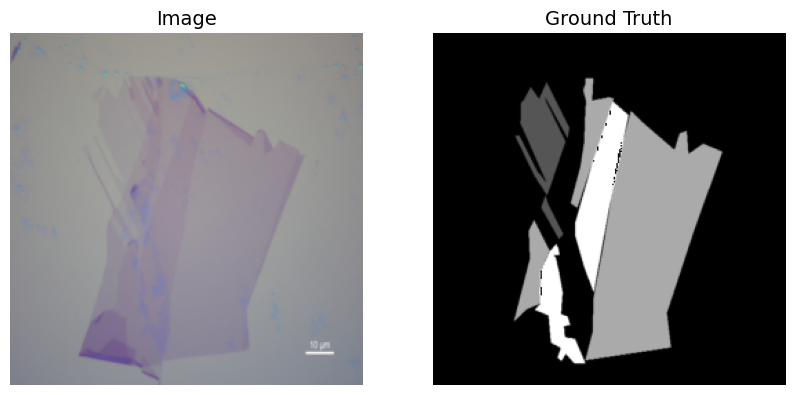

In [ ]:
#@title `dataset_train.load_image{mask}(index)` { run: "auto"}
index = 18 #@param {type:"slider", min:0, max:147, step:1}

print_img_msk(dataset_train.load_image(index), dataset_train.load_mask(index)[0])

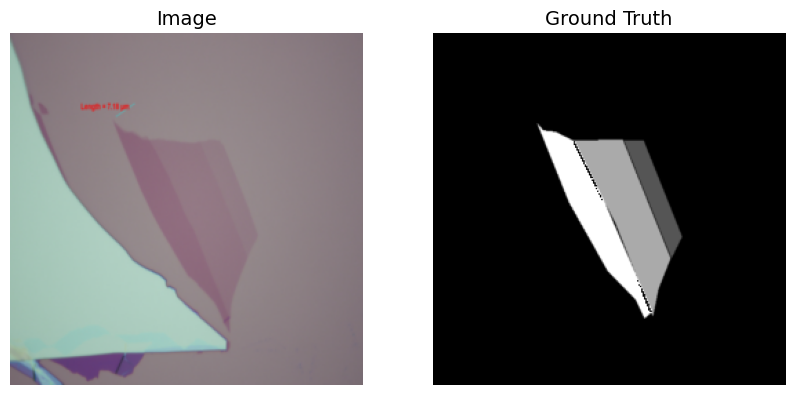

In [ ]:
#@title `dataset_val.load_image{mask}(index)` { run: "auto"}
index = 3 #@param {type:"slider", min:0, max:17, step:1}

print_img_msk(dataset_val.load_image(index), dataset_val.load_mask(index)[0])

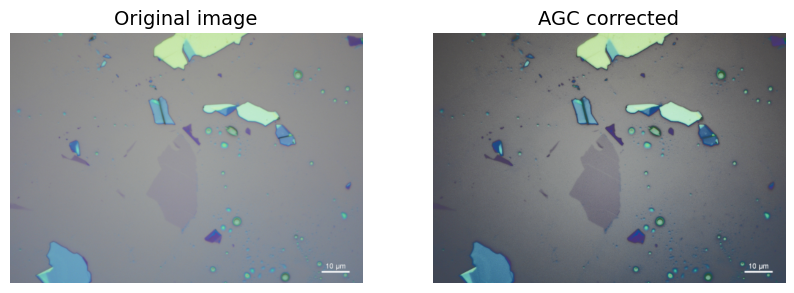

In [ ]:
#@title Print Gamma corrected { run: "auto"}
index = 33 #@param {type:"slider", min:0, max:147, step:1}

image = dataset_train.load_image(index)
corrected_image = dataset_train.load_image(index, corrected=True)
print_images([image, corrected_image], ["Original image", "AGC corrected"])

## Data loader

In [ ]:
#@title Image augmentor
import torchvision.transforms.functional as TF
import random

class Augmenter:
  def __init__(self, vert_flip_prob, hor_flip_prob, randomAffine):
    self.vert_flip_prob = vert_flip_prob
    self.hor_flip_prob = hor_flip_prob
    self.randomAffine = randomAffine

  def __call__(self, images, masks):
    if random.random() > self.vert_flip_prob:
      images = TF.vflip(images)
      masks = TF.vflip(masks)
    if random.random() > self.hor_flip_prob:
      images = TF.hflip(images)
      masks = TF.hflip(masks)

    params = self.randomAffine.get_params(self.randomAffine.degrees, self.randomAffine.translate, self.randomAffine.scale, self.randomAffine.shear, images.shape[-2:][::-1])
    images = TF.affine(images, *params)
    masks = TF.affine(masks, *params)

    return images, masks

In [ ]:
random_aug = Augmenter(0.5, 0.5, transforms.RandomAffine(degrees=(0,360), translate=(0.2, 0.2), scale=(0.7, 1.5), shear=(0, 0.2, 0, 0.2)))

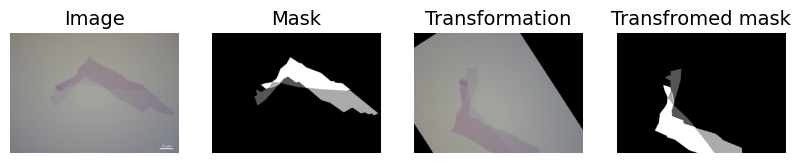

In [ ]:
#@title Show augmenatation results. { run:'auto' }

index = 7 #@param {type: 'slider', min:0, max:57, step:1}

image = dataset_train.load_image(index, corrected=APPLY_GAMMA_CORRECTION).to(torch.float)
mask = dataset_train.load_mask(index)[0]
intens_ml = 255 // 3
intens_bl = 2 * intens_ml
intens_3l = 3 * intens_ml
mask = (mask[label_to_ind['ML']] * intens_ml + 
        mask[label_to_ind['BL']] * intens_bl +
        mask[label_to_ind['3L']] * intens_3l).unsqueeze(0)

timg, tmsk = random_aug(image, mask)

print_images([image.to(torch.uint8), mask.to(torch.uint8), timg.to(torch.uint8), tmsk], 
             ["Image", "Mask", "Transformation", "Transfromed mask"], 
             [{}, {'cmap':'gray'}, {}, {'cmap':'gray'}])

In [ ]:
#@title Normalization Functions

default_normalizer = transforms.Normalize(IMAGENET_MEAN, IMAGENET_VAR)
default_mean_unnormalizer = torch.FloatTensor(IMAGENET_MEAN)[None, :, None, None]
default_var_unnormalizer = torch.FloatTensor(IMAGENET_VAR)[None, :, None, None]

def normalize(image: torch.Tensor):
  return default_normalizer(image)

def unnormalize(normalized_image: torch.Tensor, device='cpu'):
  three_dims = False
  if normalized_image.ndim == 3:
    three_dims = True
    normalized_image = normalized_image.unsqueeze(0)
  result = normalized_image * default_var_unnormalizer.to(device) + default_mean_unnormalizer.to(device)
  if three_dims:
    return result.squeeze()
  return result


In [ ]:
#@title Data loader

def data_loader(dataset, augmentor=None, batch_size=DEFAULT_BATCH_SIZE, image_size=DEFAULT_IMAGE_SIZE, choose_unique=False, corrected=APPLY_GAMMA_CORRECTION):
  
  resizer = transforms.Resize(image_size, antialias=True)

  while True: 
    
    #extract a random batch 
    batch = np.random.choice(dataset.image_ids, size = batch_size, replace=not choose_unique)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #preprocess the raw images 
        raw = dataset.load_image(f, corrected) / 255.

        raw = normalize(resizer(raw))

        #get the mask
        mask = dataset.load_mask(f)[0]
        mask = resizer(mask)

        # pre-process the mask 
        mask[mask != 0] = 1
        batch_x.append(raw)
        batch_y.append(mask)

    # pre-process a batch of images and masks 
    batch_x = torch.stack(batch_x, dim=0) # normalize raw images
    batch_y = torch.stack(batch_y, dim=0).to(torch.float) # casting to float

    if augmentor:
        # augment images and masks
        batch_x, batch_y = augmentor(batch_x, batch_y)

    yield (batch_x, batch_y)

In [ ]:
#@title Creating generator for training and testing
train_generator = data_loader(dataset_train, augmentor=random_aug, batch_size=TRAIN_BATCH_SIZE,image_size=DEFAULT_IMAGE_SIZE, choose_unique=False, corrected=APPLY_GAMMA_CORRECTION)

val_generator = data_loader(dataset_val, augmentor=None, batch_size=VAL_BATCH_SIZE, image_size=DEFAULT_IMAGE_SIZE, choose_unique=True, corrected=APPLY_GAMMA_CORRECTION)

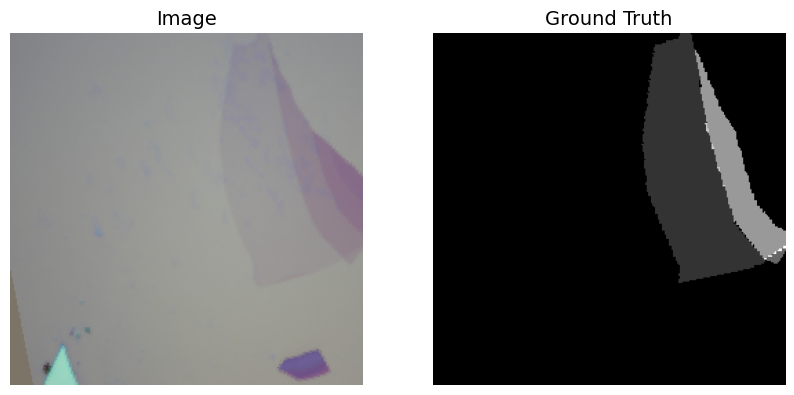

In [ ]:
#@title Looking at trian generator
x, y = next(train_generator) # x is the raw images, y is the ground truth masks

img = x[0]
msk = y[0]

print_images([unnormalize(img), msk[label_to_ind['ML']] * (255//3) + msk[label_to_ind['BL']] * 2 * (255//3) + msk[label_to_ind['3L']] * 3 * (255 // 3)], ['Image', 'Ground Truth'], [{}, {'cmap': 'gray'}])

## Training

In [ ]:
#@title Lightning model class

class LitOCR(pl.LightningModule):
  def __init__(self, num_classes, class_weights, load_scraped=True, apply_gamma_correction=False, backbone='resnet', fine_loss_weight=1, coarse_loss_weight=0, learning_rate=1e-5):
    super().__init__()
    assert num_classes == class_weights.shape[0]

    # self hyperparams for later access
    self.num_classes = num_classes
    self.class_weights = class_weights
    self.load_scraped = load_scraped
    self.apply_gamma_correction = apply_gamma_correction
    self.backbone = backbone
    self.learning_rate = learning_rate
    self.fine_loss_weight = fine_loss_weight
    self.coarse_loss_weight = coarse_loss_weight
    # log hyperparams
    self.save_hyperparameters()

    # get a model
    self.model = get_ocr_model(num_classes, backbone)
    # configure a loss
    self.loss = torch.nn.CrossEntropyLoss(weight=class_weights / class_weights.sum())

    # configure metrics for train
    self.train_miou = torchmetrics.classification.JaccardIndex(task='multiclass', num_classes=num_classes, average='macro')
    self.train_precision = torchmetrics.classification.Precision(task='multiclass', num_classes=num_classes, average='macro')
    self.train_recall = torchmetrics.classification.Recall(task='multiclass', num_classes=num_classes, average='macro')
    # configure metrics for val
    self.val_miou = torchmetrics.classification.JaccardIndex(task='multiclass', num_classes=num_classes, average='macro')
    self.val_precision = torchmetrics.classification.Precision(task='multiclass', num_classes=num_classes, average='macro')
    self.val_recall = torchmetrics.classification.Recall(task='multiclass', num_classes=num_classes, average='macro')
    
    # self.batch_losses = []

  def training_step(self, batch, batch_idx):
    image, target = batch
    preds, loss = self._get_preds_loss(image, target)

    self._calculate_metrics(preds, target.argmax(dim=1),
                            self.train_miou, 
                            self.train_precision, 
                            self.train_recall)
    
    self.log_dict({'train/loss': loss, 
                   'train/miou': self.train_miou,
                   'train/precision': self.train_precision, 
                   'train/recall': self.train_recall},
                  on_epoch=True,
                  on_step=False,
                  )
    
    return loss

  def validation_step(self, batch, batch_idx):
    image, target = batch
    preds, loss = self._get_preds_loss(image, target)

    self._calculate_metrics(preds, target.argmax(dim=1),
                            self.val_miou,
                            self.val_precision,
                            self.val_recall,
                            )
    
    self.log_dict({'val/loss': loss, 
                   'val/miou': self.val_miou,
                   'val/precision': self.val_precision, 
                   'val/recall': self.val_recall},
                  )

    return loss
    

  def _get_preds_loss(self, image, target):
    coarse, preds = self.model(image)
    loss = self.fine_loss_weight * self.loss(preds, target) + self.coarse_loss_weight * self.loss(coarse, target)
    return preds, loss

  def _calculate_metrics(self, preds, target, miou, precision, recall):
    miou(preds, target)
    precision(preds, target)
    recall(preds, target)

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

  def forward(self, image):
    _, preds = self.model(image)
    return preds

In [ ]:
#@title Lightning model

lit_model = LitOCR(num_classes=NUM_CLASSES,
                   class_weights=CLASS_WEIGHTS, 
                   load_scraped=LOAD_SCRAPED,
                   apply_gamma_correction=APPLY_GAMMA_CORRECTION,
                   backbone=BACKBONE,
                   fine_loss_weight=FINE_LOSS_WEIGHT,
                   coarse_loss_weight=COARSE_LOSS_WEIGHT,
                   learning_rate=LEARNING_RATE,
                   )

2023-04-23 11:44:57,626 INFO    [module_helper.py, 129] Loading pretrained model:./models/OCRNet/pretrained/hrnetv2_w48_imagenet_pretrained.pth
2023-04-23 11:45:01,793 INFO    [module_helper.py, 145] Missing keys: []


In [ ]:
#@title Prediction pictures from images

def get_pictures(preds):
  assert preds.ndim in [3, 4]
  # add a dimension if necessary to work uniformly
  three_dim = False
  if preds.ndim == 3:
    three_dim = True
    preds = preds.unsqueeze(0)
  
  # create segmentation from predictions
  preds = preds.argmax(dim=1,keepdim=True)
  segm = torch.zeros(size=(preds.shape[0], 3, preds.shape[2], preds.shape[3])).to(device)#.to(torch.uint8).to(device)
  for label, ind in label_to_ind.items():
    segm += (preds == ind) * label_to_color[label].to(device)[None, :, None, None]
  
  # reduce a dimension if necessary
  if three_dim:
    return segm.squeeze()
  return segm


def get_prediction_pictures(images: torch.Tensor, model):
  assert images.ndim in [3, 4]
  # add a dimension if necessary to work uniformly
  three_dim = False
  if images.ndim == 3:
    three_dim = True
    images = images.unsqueeze(0)
  
  # get predictions
  preds = model(images)

  # reduce a dimension if necessary
  if three_dim:
    return get_pictures(preds).squeeze()
  return get_pictures(preds)

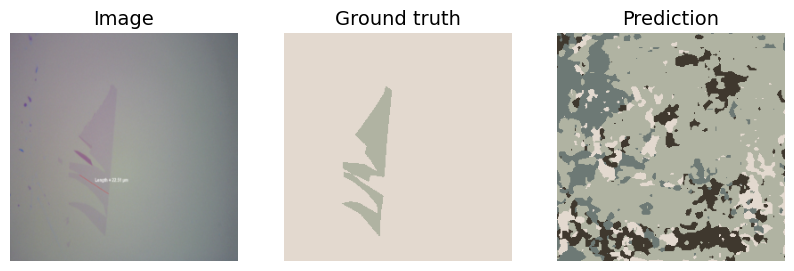

In [ ]:
#@title Check functions that get a picture from predictions
for image, true_mask in val_generator:
  image = image[0].to(device)
  pred_segm = get_prediction_pictures(image.to(torch.float), lit_model.to(device))

  true_mask = true_mask[0].to(device)
  true_segm = get_pictures(true_mask)
  print_images([unnormalize(image, device), true_segm.to(torch.uint8), pred_segm.to(torch.uint8)], ['Image', 'Ground truth', 'Prediction'])
  break

In [ ]:
#@title Logging checkpoint

class PredictionsLogger(pl.callbacks.Callback):

  def __init__(self,
               log_n_pictures=5,
               log_every_n_epochs = 1,
               plot_n_pictures = 0,
               plot_every_n_epochs = 0):
    super().__init__()
    
    self.epoch_counter = 0
    
    assert log_n_pictures <= dataset_val.num_images
    assert plot_n_pictures <= dataset_val.num_images

    self.log_n_pictures = log_n_pictures
    self.log_every_n_epochs = log_every_n_epochs
    self.plot_n_pictures = plot_n_pictures
    self.plot_every_n_epochs = plot_every_n_epochs

  def on_train_epoch_end(self, trainer, pl_module):
    pl_module.eval()
    table = wandb.Table(['Image', 'Ground Truth', 'Prediction'])
    if self.epoch_counter % self.plot_every_n_epochs == 0:
      print(f'===== EPOCH {self.epoch_counter} =====')
    with torch.no_grad():
      for idx in range(dataset_val.num_images):
        if idx >= max(self.plot_n_pictures, self.log_n_pictures):
          break
        image = normalize(default_resizer(dataset_val.load_image(idx, corrected=pl_module.apply_gamma_correction) / 255.)).to(device)       
        pred_segm = get_prediction_pictures(image.to(torch.float), pl_module)
        
        true_mask = default_resizer(dataset_val.load_mask(idx)[0]).to(device)
        true_segm = get_pictures(true_mask)

        if idx < self.log_n_pictures:
          table.add_data(wandb.Image(unnormalize(image, device).permute((1, 2, 0)).cpu().numpy()), # convetring to numpy, because torch.Tensor.clump_(a, b) doesn't work if tensor is int and a, b are floats
                        wandb.Image(true_segm.permute((1, 2, 0)).cpu().numpy()), 
                        wandb.Image(pred_segm.permute((1, 2, 0)).cpu().numpy()),
                        )
        if self.epoch_counter % self.plot_every_n_epochs == 0 and idx < self.plot_n_pictures:
          print_images([(255 * unnormalize(image, device)).to(torch.uint8), true_segm.to(torch.uint8), pred_segm.to(torch.uint8)], 
                       ['Image', 'Ground Truth', 'Prediction'],
                       [{}, {'cmap':'gray'}, {'cmap':'gray'}])
    
    if self.epoch_counter % self.log_every_n_epochs == 0:
      wandb.log({'segmentation_table': table}, commit=False)
    
    self.epoch_counter += 1


In [ ]:
#@title Configuring predictions logger and printer

prediction_logger = PredictionsLogger(log_n_pictures=dataset_val.num_images, plot_n_pictures=5, plot_every_n_epochs=5)

In [ ]:
#@title Logger

def get_run_name(model: LitOCR):
  return f'ocr_{model.backbone}_{"whole-data" if model.load_scraped else "no-scraped-data"}_{"with-correction" if model.apply_gamma_correction else "no-correction"}'

wandb_logger = pl.loggers.WandbLogger(save_dir=LOG_DIR,
                                      name=get_run_name(lit_model))

wandb: Currently logged in as: iluxa-kholkin (graphene). Use `wandb login --relogin` to force relogin


In [ ]:
#@title Checkpoint callback

checkpoint_save = pl.callbacks.ModelCheckpoint(dirpath=CHECKPOINT_DIR,
                                               filename=wandb.run.name + '_{epoch}',
                                               monitor='val/loss',
                                               mode='min',
                                               save_top_k=1,
                                               )

In [ ]:
#@title Trainer

trainer = pl.Trainer(default_root_dir=OCR_DIR,
                     limit_train_batches=TRAIN_BATCHES,
                     limit_val_batches=VAL_BATCHES,
                     callbacks=[checkpoint_save, prediction_logger],
                     max_epochs=MAX_EPOCHS,
                     logger=wandb_logger,
                     )

INFO: GPU available: True (cuda), used: True
2023-04-23 11:45:12,737 INFO    GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2023-04-23 11:45:12,741 INFO    TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2023-04-23 11:45:12,746 INFO    IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2023-04-23 11:45:12,749 INFO    HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
2023-04-23 11:45:12,752 INFO    `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [ ]:
trainer.fit(model=lit_model, train_dataloaders=train_generator, val_dataloaders=val_generator)

Output hidden; open in https://colab.research.google.com to view.

## Gather statistics

In [ ]:
#@title Report table logging function
from sklearn.metrics import classification_report, confusion_matrix

def log_report_table(y_true, y_pred, class_names, metrics, table_name):
  report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
  table = wandb.Table(['class', *metrics])
  for class_name in class_names:
    table.add_data(class_name, *[report[class_name][metric] for metric in metrics])
  wandb.log({table_name:table})

In [ ]:
#@title Prediction and target extracting function
def get_pred_target(dataset: Dataset, model: LitOCR, device='cuda'):
  with torch.no_grad():
    preds = []
    targets = []
    for i in tqdm(range(dataset.num_images), position=0, leave=True):
      image = normalize(default_resizer(dataset.load_image(i, corrected=APPLY_GAMMA_CORRECTION) / 255.).to(device))
      preds.append(model(image[None, :, :, :]).squeeze().cpu().numpy().argmax(axis=0))
      targets.append(default_resizer(dataset.load_mask(i)[0]).cpu().numpy().argmax(axis=0))
  return np.concatenate(preds, axis=0).flatten(), np.concatenate(targets, axis=0).flatten()

In [ ]:
#@title load a checkpoint

# BEST_MODEL_PATH = checkpoint_save.best_model_path 
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, 'ocr_resnet_whole-data_no-correction_epoch=43.ckpt')

lit_model = LitOCR.load_from_checkpoint(BEST_MODEL_PATH)
lit_model.eval()
None

2023-04-26 06:16:17,268 INFO    [module_helper.py, 117] Loading pretrained model:./models/OCRNet/pretrained/resnet101-imagenet.pth


In [ ]:
#@title Get train predictions and targets
train_pred, train_target = get_pred_target(dataset_train, lit_model)

100%|██████████| 148/148 [00:07<00:00, 20.88it/s]


In [ ]:
#@title Get val predictions and targets
val_pred, val_target = get_pred_target(dataset_val, lit_model)

100%|██████████| 18/18 [00:01<00:00, 16.12it/s]


In [ ]:
#@title Look at classification reports

train_report = classification_report(train_target, train_pred, target_names=list(label_to_name.values()))
print(f'===== TRAIN REPORT ====\n{train_report}')

val_report = classification_report(val_target, val_pred, target_names=list(label_to_name.values()))
print(f'===== VAL REPORT ====\n{val_report}')

===== TRAIN REPORT ====
              precision    recall  f1-score   support

   Backgroun       0.99      0.96      0.97   9185821
   Monolayer       0.63      0.81      0.71    239113
     Bilayer       0.36      0.84      0.51    207903
Three layers       0.77      0.85      0.81     66491

    accuracy                           0.95   9699328
   macro avg       0.69      0.86      0.75   9699328
weighted avg       0.97      0.95      0.96   9699328

===== VAL REPORT ====
              precision    recall  f1-score   support

   Backgroun       0.99      0.96      0.97   1089220
   Monolayer       0.57      0.70      0.63     29078
     Bilayer       0.61      0.80      0.69     57654
Three layers       0.17      0.44      0.25      3696

    accuracy                           0.95   1179648
   macro avg       0.59      0.73      0.64   1179648
weighted avg       0.96      0.95      0.95   1179648



In [ ]:
#@title Log classification reports

metrics = ['precision', 'recall', 'f1-score', 'support']
log_report_table(train_target, train_pred, label_to_name.values(), metrics, 'train/report')
log_report_table(val_target, val_pred, label_to_name.values(), metrics, 'val/report')

In [ ]:
#@title Log confusion matrix

wandb.log({'val/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                              y_true=val_target, 
                                                              preds=val_pred,
                                                              class_names=list(label_to_name.values()),
                                                              )
})

wandb.log({'train/confusion_matrix': wandb.plot.confusion_matrix(probs=None,
                                                                y_true=train_target, 
                                                                preds=train_pred,
                                                                class_names=list(label_to_name.values()),
                                                                )
})

In [ ]:
#@title Print predicitons and get metrics
def get_val_prec_rec_iou(model, device='cpu'):
  model.eval()
  iou = torchmetrics.classification.JaccardIndex(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)
  precision = torchmetrics.classification.Precision(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)
  recall = torchmetrics.classification.Recall(task='multiclass', num_classes=NUM_CLASSES, average='macro').to(device)

  for images, targets in val_generator:
    pred = model(images.to(device))
    targets = torch.argmax(targets.to(device), dim=1)


    pred = torch.argmax(pred, dim=1, keepdim=True)
    segm = torch.zeros(size=(pred.shape[0], 3, pred.shape[2], pred.shape[3])).to(device)
    true_segm = torch.zeros(size=(pred.shape[0], 3, pred.shape[2], pred.shape[3])).to(device)
    for label, ind in label_to_ind.items():
      segm += (pred == ind) * label_to_color[label].to(device)[None, :, None, None]
      true_segm += (targets[:, None, :, :] == ind) * label_to_color[label].to(device)[None, :, None, None]


    pred_segm = get_prediction_pictures(images.to(device), model)
    # print(torch.cat(images.split(1), dim=1).shape)

    pred = pred.squeeze()

    print_images([torch.cat(unnormalize(images).split(1), dim=2).squeeze().to(torch.float), 
                  torch.cat(true_segm.split(1), dim=2).squeeze().to(torch.uint8),
                  torch.cat(segm.split(1), dim=2).squeeze().to(torch.uint8)], 
                 ["Image", "Ground Truth", "Segmentation"])


    precision(pred, targets)
    recall(pred, targets)
    iou(pred, targets)
    break

  return precision.compute(), recall.compute(), iou.compute()
  

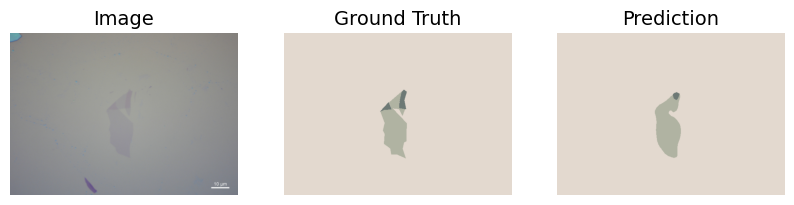

In [ ]:
image = normalize(dataset_train.load_image(0) / 255.).to(device)
mask = get_pictures(dataset_train.load_mask(0)[0].to(device))

pred = get_prediction_pictures(image, lit_model)


print_images([unnormalize(image, 'cuda'), mask.to(torch.uint8), pred.to(torch.uint8)], ["Image", "Ground Truth", "Prediction"])



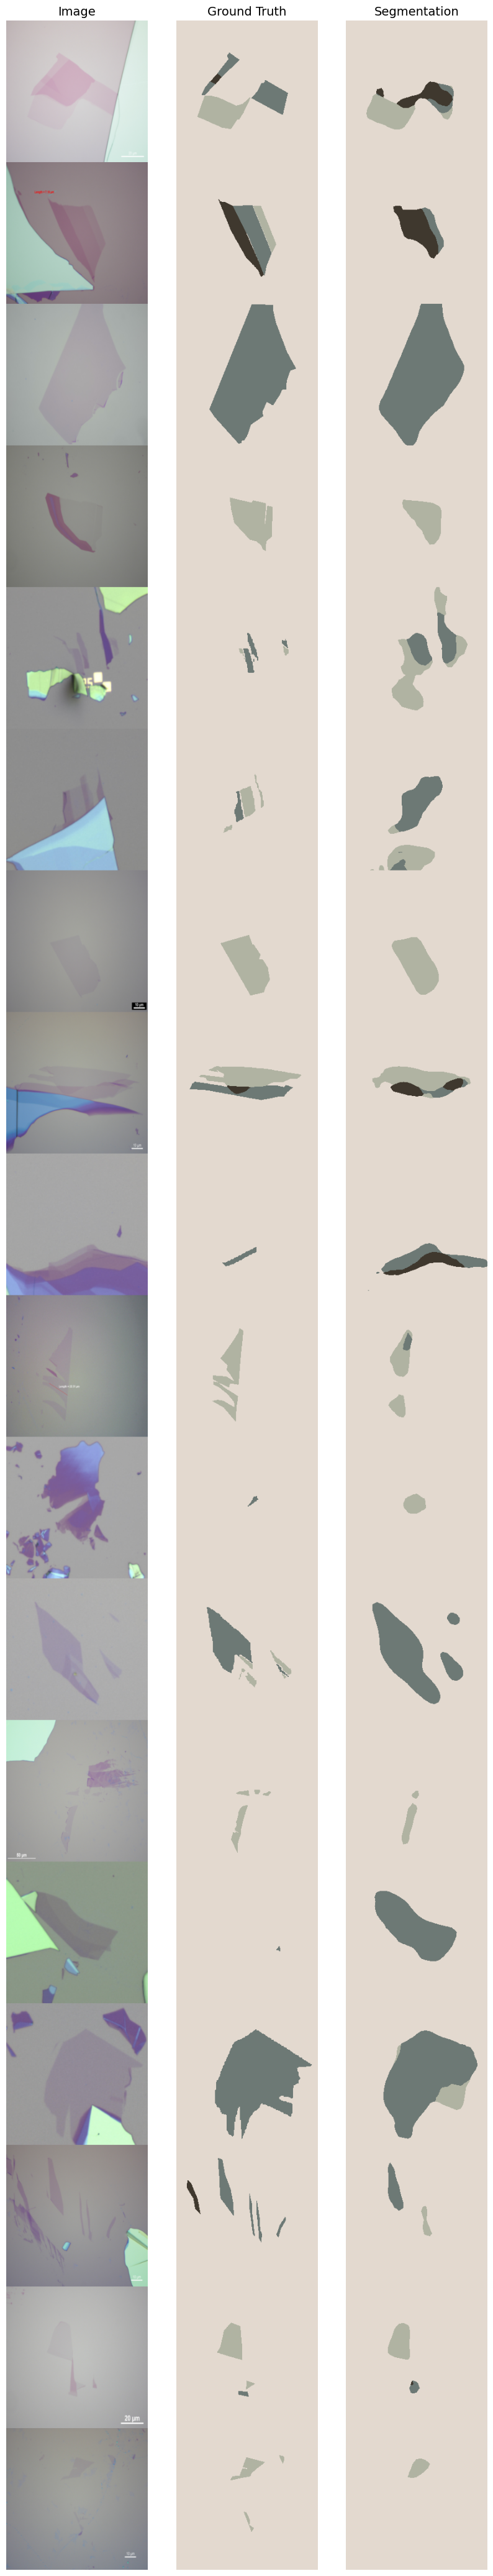

In [ ]:
metrics = get_val_prec_rec_iou(lit_model, 'cuda')
torch.cuda.empty_cache()

In [ ]:
metrics

(tensor(0.5850, device='cuda:0'),
 tensor(0.7254, device='cuda:0'),
 tensor(0.5198, device='cuda:0'))

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/miou,▁▃▄▅▆▇▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██▇████
train/precision,▁▁▄▅▆▇▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████
train/recall,▁▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████████████
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▁▂▁▂▂▁▂▁
val/miou,▁▄▇▇▆▇▆█▇███▇▇█▇██▇█▇▇█▇▆▇▇▆▇▇▇▇█▇█▇▇█▆▇
val/precision,▁▃▆▅▆█▆▇▆▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▆▇▆▆▇▆▇▇▇▆▇▆▇▇▆▇
val/recall,▁▂▆▅▅▅▆▇██▇█▇▇█▇██▇█▇▆▇▆▆▇▇▆▇▆▇▇▇██▇▇▇▅▇
epoch,49


In [ ]:
torch.cuda.empty_cache()